Вот скрипт, который загружает обученную модель, применяет её к тому же датафрейму и добавляет новую колонку с прогнозами (PREDICTION).

Что делает этот скрипт:  
Загружает данные из базы, как и в обучающем скрипте.  
Кодирует свечи (используется тот же алгоритм CANDLE_CODE).  
Преобразует коды свечей в числовые метки (CANDLE_INT).  
Определяет структуру нейросети, чтобы она совпадала с обученной.  
Загружает веса модели из best_model_02.pth.  
Прогнозирует движение цены (1 – рост, 0 – падение).  
Добавляет колонку PREDICTION в датафрейм.  
Сохраняет результат в predictions.csv.  
Теперь в файле predictions.csv у вас будет таблица с прогнозами. 🚀  

In [3]:
import sqlite3
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from pathlib import Path

# === 1. ЗАГРУЗКА ДАННЫХ ===
# db_path = Path(r'C:\Users\Alkor\gd\data_quote_db\RTS_futures_options_day.db')

# with sqlite3.connect(db_path) as conn:
#     df_fut = pd.read_sql_query(
#         "SELECT TRADEDATE, OPEN, LOW, HIGH, CLOSE, VOLUME FROM Futures",
#         conn
#     )

db_path = Path(r'C:\Users\Alkor\gd\data_quote_db\RTS_futures_day.db')

with sqlite3.connect(db_path) as conn:
    df_fut = pd.read_sql_query(
        "SELECT TRADEDATE, OPEN, LOW, HIGH, CLOSE, VOLUME FROM Day",
        conn
    )

# === 2. ФУНКЦИЯ КОДИРОВАНИЯ СВЕЧЕЙ (ЛИХОВИДОВ) ===
def encode_candle(row):
    open_, low, high, close = row['OPEN'], row['LOW'], row['HIGH'], row['CLOSE']

    direction = 1 if close > open_ else (0 if close < open_ else 2)
    upper_shadow = high - max(open_, close)
    lower_shadow = min(open_, close) - low
    body = abs(close - open_)

    def classify_shadow(shadow, body):
        return 0 if shadow < 0.1 * body else (1 if shadow < 0.5 * body else 2)

    return f"{direction}{classify_shadow(upper_shadow, body)}{classify_shadow(lower_shadow, body)}"

df_fut['CANDLE_CODE'] = df_fut.apply(encode_candle, axis=1)

# === 3. ПРЕОБРАЗОВАНИЕ КОДОВ В ЧИСЛА ===
unique_codes = sorted(df_fut['CANDLE_CODE'].unique())
code_to_int = {code: i for i, code in enumerate(unique_codes)}
df_fut['CANDLE_INT'] = df_fut['CANDLE_CODE'].map(code_to_int)

window_size = 20  

# === 4. ОПРЕДЕЛЕНИЕ МОДЕЛИ (ДОЛЖНА СОВПАДАТЬ С ОБУЧЕННОЙ) ===
class CandleLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(CandleLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return self.sigmoid(x)

# === 5. ЗАГРУЗКА ОБУЧЕННОЙ МОДЕЛИ ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "best_model_first.pth"
model = CandleLSTM(
    vocab_size=len(unique_codes), embedding_dim=8, hidden_dim=32, output_dim=1
    ).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# === 6. ПРОГНОЗИРОВАНИЕ ===
predictions = []
with torch.no_grad():
    for i in range(len(df_fut) - window_size):
        sequence = torch.tensor(
            df_fut['CANDLE_INT'].iloc[i:i+window_size].values, dtype=torch.long
            ).unsqueeze(0).to(device)
        pred = model(sequence).item()
        predictions.append(1 if pred > 0.5 else 0)

# Заполняем колонку PREDICTION (первые window_size значений - NaN)
df_fut['PREDICTION'] = [None] * window_size + predictions

# === 7. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ===
df_fut.to_csv("predictions_first_model.csv", index=False)
print("✅ Прогнозы сохранены в 'predictions_first_model'")


✅ Прогнозы сохранены в 'predictions_first_model'


In [4]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# === 1. ЗАГРУЗКА РЕЗУЛЬТАТОВ ===
df_fut = pd.read_csv("predictions_first_model.csv")

# === 2. ДОБАВЛЯЕМ ФАКТИЧЕСКИЙ НАПРАВЛЕНИЕ ЦЕНЫ ===
df_fut['ACTUAL'] = (df_fut['CLOSE'].diff() > 0).astype(int)

# Убираем первые `window_size` значений, где нет прогноза
df_fut = df_fut.dropna(subset=['PREDICTION'])

# Преобразуем в int
df_fut['PREDICTION'] = df_fut['PREDICTION'].astype(int)

# === 3. ОЦЕНКА ТОЧНОСТИ ===
accuracy = accuracy_score(df_fut['ACTUAL'], df_fut['PREDICTION'])
print(f"✅ Точность модели: {accuracy:.2%}")

# === 4. ВЫВОД МАТРИЦЫ ОШИБОК ===
conf_matrix = confusion_matrix(df_fut['ACTUAL'], df_fut['PREDICTION'])
print("\n📊 Матрица ошибок:\n", conf_matrix)

# === 5. ПОДРОБНЫЙ ОТЧЁТ ПО КЛАССАМ ===
report = classification_report(
    df_fut['ACTUAL'], df_fut['PREDICTION'], target_names=["⬇ Падение", "⬆ Рост"]
    )
print("\n📋 Отчет о качестве предсказаний:\n", report)

✅ Точность модели: 50.53%

📊 Матрица ошибок:
 [[561 646]
 [607 719]]

📋 Отчет о качестве предсказаний:
               precision    recall  f1-score   support

   ⬇ Падение       0.48      0.46      0.47      1207
      ⬆ Рост       0.53      0.54      0.53      1326

    accuracy                           0.51      2533
   macro avg       0.50      0.50      0.50      2533
weighted avg       0.50      0.51      0.50      2533



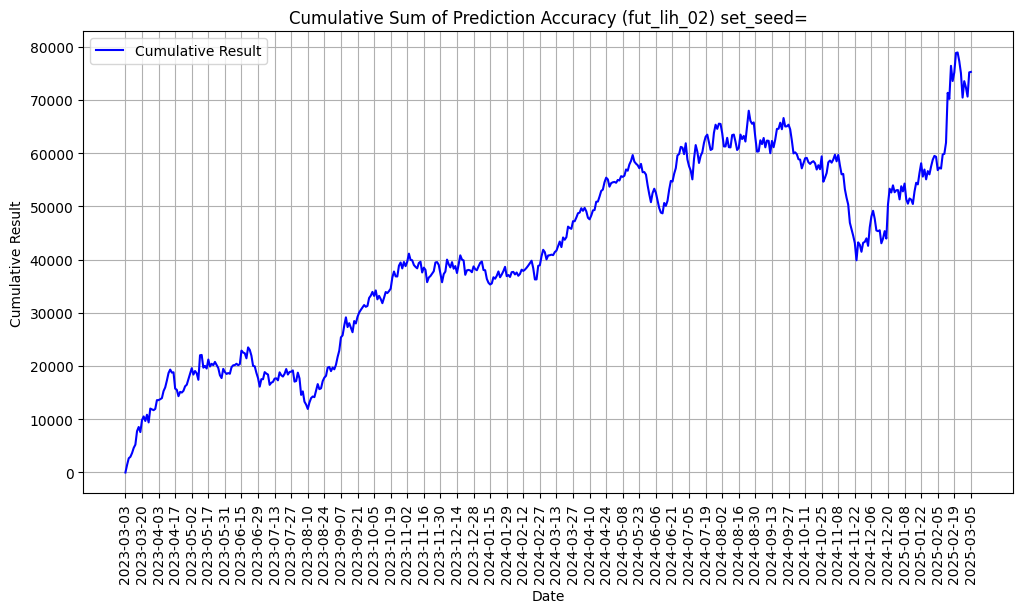

In [5]:
'''
Здесь используется смещение колонки прогноза для сравнения прогноза и факта.
'''
import pandas as pd
import matplotlib.pyplot as plt

# === 1. ЗАГРУЗКА ФАЙЛА И ОТБОР ПОСЛЕДНИХ 20% ===
df = pd.read_csv("predictions_first_model.csv")

split = int(len(df) * 0.8)  # 80% - обучающая выборка, 20% - тестовая
df = df.iloc[split:].copy()  # Берем последние 20%

# === 2. СМЕЩЕНИЕ ПРОГНОЗА НА ОДИН БАР ВПЕРЁД ===
df["PREDICTION_SHIFTED"] = df["PREDICTION"].shift(1)  # Смещаем вверх

# df

# === 3. РАСЧЁТ РЕЗУЛЬТАТОВ ПРОГНОЗА ===
def calculate_result(row):
    if pd.isna(row["PREDICTION_SHIFTED"]):  # Если NaN после сдвига
        return 0  # Можно удалить или оставить 0

    true_direction = 1 if row["CLOSE"] > row["OPEN"] else 0
    predicted_direction = row["PREDICTION_SHIFTED"]

    difference = abs(row["CLOSE"] - row["OPEN"])
    return difference if true_direction == predicted_direction else -difference

df["RESULT"] = df.apply(calculate_result, axis=1)

# === 4. ПОСТРОЕНИЕ КУМУЛЯТИВНОГО ГРАФИКА ===
df["CUMULATIVE_RESULT"] = df["RESULT"].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(df["TRADEDATE"], df["CUMULATIVE_RESULT"], label="Cumulative Result", color="b")
plt.xlabel("Date")
plt.ylabel("Cumulative Result")
plt.title("Cumulative Sum of Prediction Accuracy (fut_lih_02) set_seed=")
plt.legend()
plt.grid()

# plt.xticks(rotation=45)
plt.xticks(df["TRADEDATE"][::10], rotation=90)
plt.show()

In [6]:
df

,TRADEDATE,OPEN,LOW,HIGH,CLOSE,VOLUME,CANDLE_CODE,CANDLE_INT,PREDICTION,PREDICTION_SHIFTED,RESULT,CUMULATIVE_RESULT
2042,2023-03-03,94940.0,94240.0,96060.0,95550.0,85297,122,17,1.0,NaN,0.0,0.0
2043,2023-03-06,95490.0,95420.0,97230.0,96910.0,88492,110,12,0.0,1.0,1420.0,1420.0
2044,2023-03-07,96980.0,95680.0,97360.0,95730.0,69937,10,3,0.0,0.0,1250.0,2670.0
2045,2023-03-09,95720.0,95000.0,96300.0,95450.0,93626,22,8,0.0,0.0,270.0,2940.0
2046,2023-03-10,95460.0,94200.0,95800.0,94750.0,74237,12,5,1.0,0.0,710.0,3650.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2548,2025-02-27,117050.0,113780.0,117070.0,113960.0,257246,0,0,1.0,0.0,3090.0,73550.0
2549,2025-02-28,114000.0,111000.0,114280.0,112840.0,174134,12,5,1.0,1.0,-1160.0,72390.0
2550,2025-03-03,112840.0,109430.0,115390.0,111100.0,256683,22,8,1.0,1.0,-1740.0,70650.0
2551,2025-03-04,111010.0,109770.0,115630.0,115560.0,187862,101,10,1.0,1.0,4550.0,75200.0
